In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Download NLTK resources (only needed once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /Users/smorse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/smorse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/smorse/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def generate_survey_data(n=300):
    ages = np.random.randint(18, 65, size=n)
    genders = np.random.choice(['Male', 'Female', 'Other'], size=n)
    sleep_hours = np.random.normal(6.5, 1.5, size=n).round(1)
    
    text_responses = np.random.choice([
        "I'm feeling overwhelmed with work.",
        "Things are going okay lately.",
        "I am very stressed and anxious about my future.",
        "Everything is great, I'm really happy!",
        "I’m tired but managing well.",
        "I don't know how to handle all this pressure.",
        "Life has been peaceful and stable.",
        "Feeling burnt out even after resting.",
        "No major issues, just the usual ups and downs.",
        "Sometimes I feel like giving up, but I keep going."
    ], size=n)
    
    risk_labels = [1 if any(kw in t.lower() for kw in ["stress", "overwhelmed", "anxious", "burnt out", "pressure", "giving up"]) else 0 for t in text_responses]
    
    return pd.DataFrame({
        'age': ages,
        'gender': genders,
        'sleep_hours': sleep_hours,
        'response': text_responses,
        'at_risk': risk_labels
    })

# Create the dataset
df = generate_survey_data()
df.head()

,age,gender,sleep_hours,response,at_risk
0,28,Other,6.2,"Everything is great, I'm really happy!",0
1,37,Other,8.0,I’m tired but managing well.,0
2,37,Male,8.1,I’m tired but managing well.,0
3,36,Female,5.3,Life has been peaceful and stable.,0
4,53,Other,4.6,I am very stressed and anxious about my future.,1


In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(cleaned)

df['cleaned_text'] = df['response'].apply(preprocess_text)
df[['response', 'cleaned_text']].head()

,response,cleaned_text
0,Life has been peaceful and stable.,life peaceful stable
1,I don't know how to handle all this pressure.,know handle pressure
2,Feeling burnt out even after resting.,feeling burnt even resting
3,I don't know how to handle all this pressure.,know handle pressure
4,I'm feeling overwhelmed with work.,feeling overwhelmed work


In [11]:
def sentiment_score(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['response'].apply(sentiment_score)
df[['response', 'sentiment']].head()

,response,sentiment
0,Life has been peaceful and stable.,0.25
1,I don't know how to handle all this pressure.,0.00
2,Feeling burnt out even after resting.,0.00
3,I don't know how to handle all this pressure.,0.00
4,I'm feeling overwhelmed with work.,0.00


In [14]:
df_encoded = pd.get_dummies(df, columns=['gender'], drop_first=True)

# Select features
features = ['age', 'sleep_hours', 'sentiment'] + [col for col in df_encoded.columns if col.startswith('gender_')]
X = df_encoded[features]
y = df_encoded['at_risk']

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [18]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        29

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [20]:
df[['response', 'sentiment', 'at_risk']].sample(10)

,response,sentiment,at_risk
76,"Sometimes I feel like giving up, but I keep go...",0.000000,1
269,"Sometimes I feel like giving up, but I keep go...",0.000000,1
136,I don't know how to handle all this pressure.,0.000000,1
105,"Everything is great, I'm really happy!",0.900000,0
14,I'm feeling overwhelmed with work.,0.000000,1
166,Life has been peaceful and stable.,0.250000,0
253,Feeling burnt out even after resting.,0.000000,1
114,"No major issues, just the usual ups and downs.",-0.140625,0
268,Feeling burnt out even after resting.,0.000000,1
171,I'm feeling overwhelmed with work.,0.000000,1


In [20]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(cleaned)

df['cleaned_text'] = df['response'].apply(preprocess_text)


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set(style="whitegrid")

# --- Visualization 1: Age Distribution by Risk Group ---
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='age', hue='at_risk', multiple='stack', palette='Set2', bins=20)
plt.title('Age Distribution by Risk Group')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='At Risk', labels=['No', 'Yes'])
plt.show()

# --- Visualization 2: Sentiment Score by Risk Group ---
plt.figure(figsize=(8,5))
sns.boxplot(x='at_risk', y='sentiment', data=df, palette='Set1')
plt.title('Sentiment Score by Risk Group')
plt.xlabel('At Risk')
plt.ylabel('Sentiment Polarity')
plt.xticks([0,1], ['No', 'Yes'])
plt.show()

# --- Visualization 3: Average Sleep Hours by Risk Group ---
plt.figure(figsize=(6,4))
sns.barplot(x='at_risk', y='sleep_hours', data=df, palette='pastel')
plt.title('Average Sleep Hours by Risk Group')
plt.xlabel('At Risk')
plt.ylabel('Average Sleep Hours')
plt.xticks([0,1], ['No', 'Yes'])
plt.show()

# --- Visualization 4: Word Cloud of At-Risk Responses ---
text = ' '.join(df.loc[df['at_risk'] == 1, 'cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in At-Risk Responses')
plt.show()

NameError: name 'df' is not defined

<Figure size 800x500 with 0 Axes>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud  # optional if you want the word cloud later

sns.set(style="whitegrid")


In [4]:
data = {
    'age': [22, 35, 58, 45, 30, 27, 40, 50],
    'at_risk': [0, 1, 1, 0, 0, 1, 0, 1],
    'sentiment': [0.1, -0.2, -0.4, 0.3, 0.0, -0.5, 0.2, -0.1],
    'sleep_hours': [7, 5, 6, 8, 7, 4, 7, 5],
    'cleaned_text': [
        "happy day", "feeling bad", "very tired", "good mood",
        "okay", "exhausted", "fine", "worried"
    ]
}

df = pd.DataFrame(data)


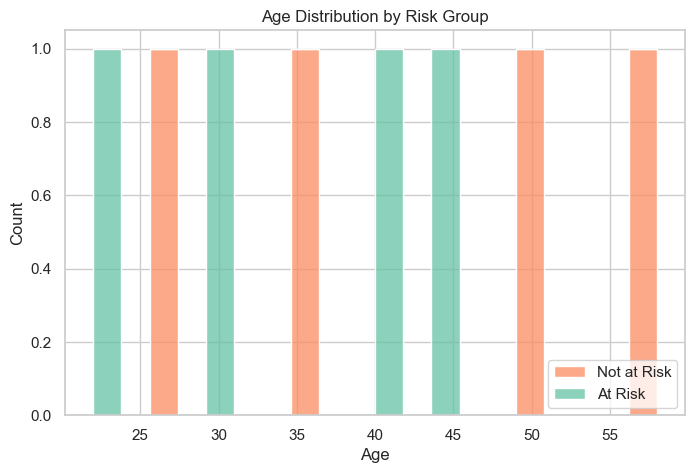

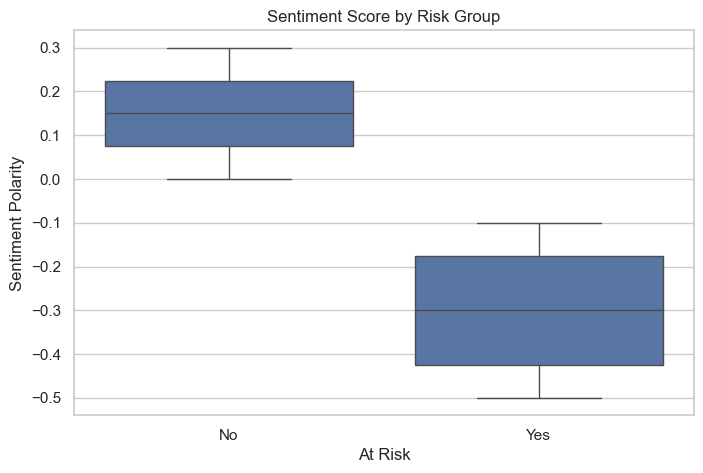

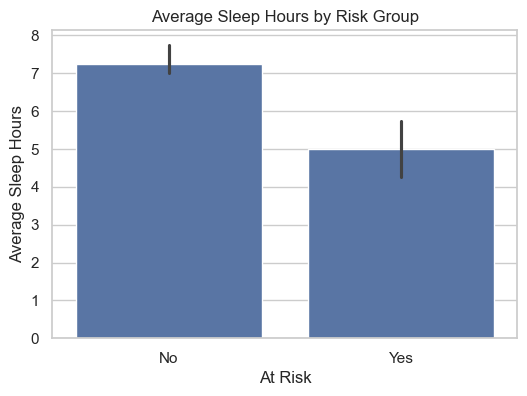

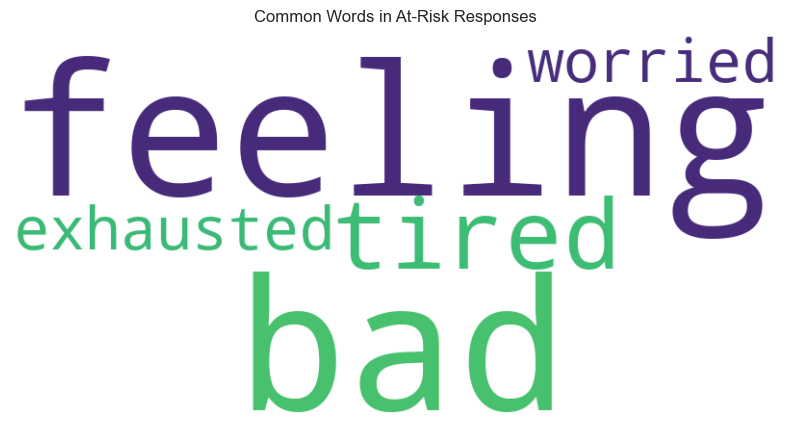

In [6]:
# Visualization 1: Age Distribution by Risk Group
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='age', hue='at_risk', multiple='stack', palette='Set2', bins=20)
plt.title('Age Distribution by Risk Group')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(['Not at Risk', 'At Risk'])
plt.show()

# Visualization 2: Sentiment Score by Risk Group
plt.figure(figsize=(8,5))
sns.boxplot(x='at_risk', y='sentiment', data=df)  # removed palette
plt.title('Sentiment Score by Risk Group')
plt.xlabel('At Risk')
plt.ylabel('Sentiment Polarity')
plt.xticks([0,1], ['No', 'Yes'])
plt.show()

# Visualization 3: Average Sleep Hours by Risk Group
plt.figure(figsize=(6,4))
sns.barplot(x='at_risk', y='sleep_hours', data=df)  # removed palette
plt.title('Average Sleep Hours by Risk Group')
plt.xlabel('At Risk')
plt.ylabel('Average Sleep Hours')
plt.xticks([0,1], ['No', 'Yes'])
plt.show()

# Visualization 4: Word Cloud of At-Risk Responses
text = ' '.join(df.loc[df['at_risk'] == 1, 'cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in At-Risk Responses')
plt.show()
